In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from scipy.integrate import quad

PATH = Path('..').resolve()
%matplotlib inline

**SAGA facts (Geha et al. 2017, Mao et al. 2020)**
 - MW has $-23 > M_K > -24.6$, or roughly a virial mass of $(0.6-2.7) \times 10^{12} M_\odot$
 - LMC has $M_r = -18.3$ | $M_* = 10^9\,M_\odot$
 - SMC has $M_r = -17.0$ | $M_* = 3\times 10^8\,M_\odot$
 - SAGA completeness limit is $M_r < -12.3$ for $D_L < 40$ Mpc, or $m_r < 20.75$
 - At $M_r < -12.3$, SAGA misses ~0.7 sat per host, and at $M_r < -15.4$, SAGA is 100% complete
 
 Also worth referencing [McConnachie 2012](https://ui.adsabs.harvard.edu/abs/2012AJ....144....4M/abstract)
 
 **Conversions**
 * From Jester et al. 2005: $M_V=M_r+0.4$
 * From Mao et al. 2020 Sec 3.6: $log (M_* / M_\odot) = 1.254 + 1.098 (g-r)_o - 0.4M_{r,o}$

# Number of galaxies we expect to see

These are based off NSA catalogs, which cover 14,500 deg$^2$ of sky and comprise ~640k galaxies out to $z < 0.05$. See https://www.sdss.org/dr14/imaging/other_info/ vs https://panstarrs.stsci.edu/, or the comparison table below


           Depth (r-band, 5sigma)   Area (deg^2)
    PS1            23.2                 31000 (note MW disk contamination)
    SDSS           22.7                 14500
    

## How many L* galaxies?

In [2]:
nsa = fits.getdata(f"{PATH}/data/nsa_v1_0_1.fits")
len(nsa)

641409

In [13]:
nsa.columns

ColDefs(
    name = 'IAUNAME'; format = '19A'
    name = 'SUBDIR'; format = '27A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'ISDSS'; format = 'J'
    name = 'INED'; format = 'J'
    name = 'ISIXDF'; format = 'J'
    name = 'IALFALFA'; format = 'J'
    name = 'IZCAT'; format = 'J'
    name = 'ITWODF'; format = 'J'
    name = 'MAG'; format = 'E'
    name = 'Z'; format = 'E'
    name = 'ZSRC'; format = '7A'
    name = 'SIZE'; format = 'E'
    name = 'RUN'; format = 'I'
    name = 'CAMCOL'; format = 'B'
    name = 'FIELD'; format = 'I'
    name = 'RERUN'; format = '3A'
    name = 'XPOS'; format = 'E'
    name = 'YPOS'; format = 'E'
    name = 'NSAID'; format = 'J'
    name = 'ZDIST'; format = 'E'
    name = 'SERSIC_NMGY'; format = '7E'
    name = 'SERSIC_NMGY_IVAR'; format = '7E'
    name = 'SERSIC_OK'; format = 'I'
    name = 'SERSIC_RNMGY'; format = '7E'
    name = 'SERSIC_ABSMAG'; format = '7E'
    name = 'SERSIC_AMIVAR'; format = '7E'
    name = 'EXTINCTIO

Note from https://www.sdss.org/dr13/manga/manga-target-selection/nsa/ that:
> The elliptical Petrosian aperture photometry is a new addition since that paper, and is considered the most reliable photometry available in this catalog. 

In [3]:
M_r_petro = nsa.ELPETRO_ABSMAG[:, 4]
M_r_sersic = nsa.SERSIC_ABSMAG[:, 4]

Text(0, 0.5, 'Sersic $M_r$')

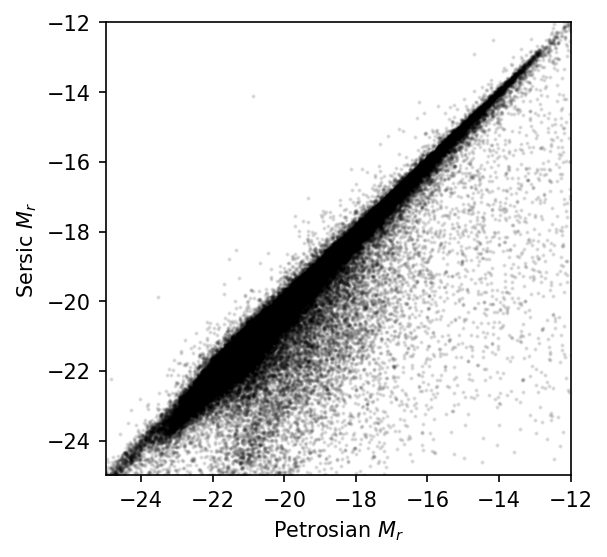

In [50]:
plt.figure(figsize=(4,4), dpi=150)
plt.scatter(M_r_petro, M_r_sersic, c='k', s=1, alpha=0.1)
plt.xlim(-25, -12)
plt.ylim(-25, -12)
plt.xlabel('Petrosian $M_r$')
plt.ylabel('Sersic $M_r$')

In [51]:
sum(nsa.Z < 0.03)

50854

In [4]:
D_L = 3e5 / 70 * nsa.Z # Mpc
3e5 / 70 * 0.03 # z=0.03 -> 130 Mpc

128.57142857142856

Note aboslute magnitude formula (including k-correction):
$$M = m - 5 \log(D_L/{\rm Mpc}) - 25 - k(z)$$

In [5]:
M_r = M_r_petro

### If the Milky Way has $M_V = -20.5$, what is its $M_r$?

In [98]:
MW_like = (M_r_petro > -21) & (M_r_petro < -20)

 Lupton et al. (2005): $V = g - 0.5784(g - r) - 0.0038$

In [6]:
M_V_estimates = nsa.ELPETRO_ABSMAG[:, 3] - 0.5784*(nsa.ELPETRO_ABSMAG[:, 3] - nsa.ELPETRO_ABSMAG[:, 4]) - 0.0038

<ipython-input-6-40cc38f77a36>:1: RuntimeWarning: invalid value encountered in subtract
  M_V_estimates = nsa.ELPETRO_ABSMAG[:, 3] - 0.5784*(nsa.ELPETRO_ABSMAG[:, 3] - nsa.ELPETRO_ABSMAG[:, 4]) - 0.0038


Text(0, 0.5, 'Sersic $M_r$')

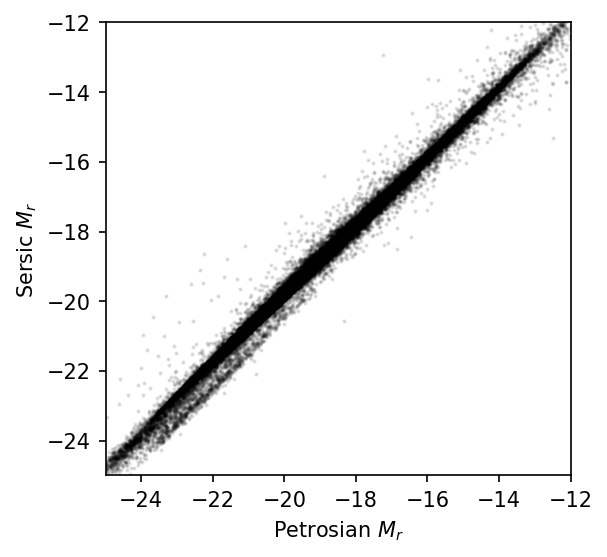

In [96]:
plt.figure(figsize=(4,4), dpi=150)
plt.scatter(M_r_petro, M_V_estimates, c='k', s=1, alpha=0.1)
plt.xlim(-25, -12)
plt.ylim(-25, -12)
plt.xlabel('Petrosian $M_r$')
plt.ylabel('Sersic $M_r$')

In [99]:
np.nanmedian(M_V_estimates[MW_like] - M_r_petro[MW_like])

0.2823162

So MW has $M_r \approx -20.8$

### ~~Set $M_r^* = -21$~~

In [54]:
sum((M_r <= -21) & (D_L < 130))

1949

### ~~$M_r^* = 5\log h - 20.44 = -21.2$ (Blanton et al. 2003)~~

~~Taken from p.656 of Mo, van den Bosch, and White. See also Section 15.3.3 for satellite luminosity functions, and 15.6 for spatial clustering.~~

~~Note that 5 log(*h*) = -1.78~~

In [55]:
sum((M_r <= 5*np.log10(0.7) - 20.44) & (D_L < 130))

1230

### try a range: $ -21.6 < M_r^* < -20.8$

In [56]:
sum((M_r > -21.6) & (M_r < -20.8) & (D_L < 130))

2330

In [57]:
sum((M_r > -21.6) & (M_r < -20.8) & (D_L < 40) & (D_L > 20))

34

### wider range: $ -21.8 < M_r^* < -20.6$

In [58]:
sum((M_r > -21.8) & (M_r < -20.6) & (D_L < 130))

3566

In [59]:
sum((M_r > -21.8) & (M_r < -20.6) & (D_L < 40) & (D_L > 20))

54

### Shift range around $M_r \sim -20.8$

In [100]:
sum((M_r > -21.3) & (M_r < -20.3) & (D_L < 130))

4952

In [101]:
sum((M_r > -21.3) & (M_r < -20.3) & (D_L < 40) & (D_L > 20))

89

### Try to get ~200 halos within 20-40 Mpc to match with SAGA 
There are ~100 MW-like halos in SDSS footprint, but note that another ~100 were thrown out due to the environment (isolation) criteria in Geha et al. 2017

In [102]:
sum((M_r > -21.8) & (M_r < -19.8) & (D_L < 41) & (D_L > 20))

219

In [103]:
sum((M_r < -19.8) & (D_L < 41) & (D_L > 20))

223

Okay cool. This is an order of magnitude exercise anyway, so we're basically there.

In [104]:
sum((M_r < -19.8) & (D_L < 64)) # z < 0.015

867

In [106]:
sum((M_r < -19.8) & (D_L < 86)) # z < 0.02

2678

In [107]:
sum((M_r < -19.8) & (D_L < 107)) # z < 0.025

5551

In [108]:
sum((M_r < -19.8) & (D_L < 130)) # z < 0.03

10044

Basically we can assume that PS1 will give us a factor of 2 in coverage relative to SDSS.

## Plot total NSA numbers against different properties

In [7]:
M_r = M_r[D_L < 130]
D_L = D_L[D_L < 130]

distances = range(20, 130, 2) # Mpc

In [73]:
len(M_r) # compared to 640k before

52109

In [74]:
halos_19p8_cdf_distances = np.array([sum((M_r < -19.8) & (D_L < d)) for d in distances])

Text(0, 0.5, 'Number')

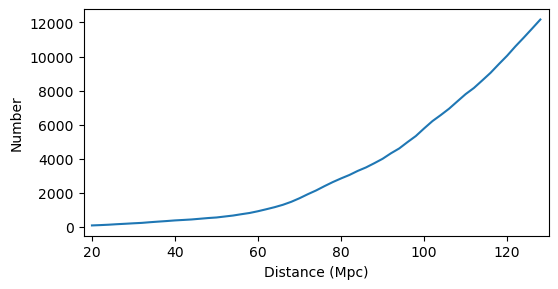

In [75]:
fig = plt.figure(figsize=(6,3), dpi=100)
ax = fig.add_subplot()

ax.plot(distances, halos_19p8_cdf_distances)
# ax.set_yscale('log')
ax.set_xlim(18, 130)
ax.set_xlabel('Distance (Mpc)')
ax.set_ylabel('Number')

### Plotting as a function of absolute magnitude (test runs)

In [78]:
colors = ['#c7e9b4', '#7fcdbb', '#41b6c4', '#1d91c0', '#225ea8', '#0c2c84']

In [81]:
# halos_cdf_distances_dict = dict()
for M_r_cutoff in [-19.5, -19.6, -19.7, -19.8, -19.9, -20]:
    if M_r_cutoff not in halos_cdf_distances_dict.keys():
        halos_cdf_distances_dict[M_r_cutoff] = np.array([sum((M_r < M_r_cutoff) & (D_L < d)) for d in distances])

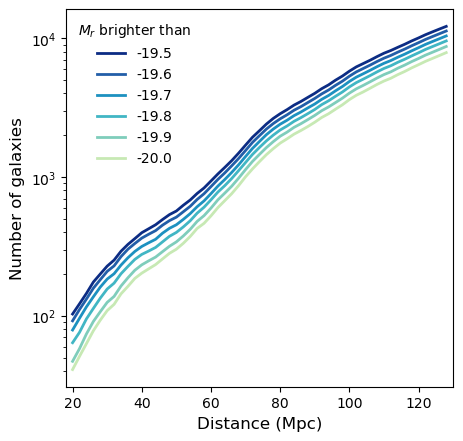

In [82]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot()

for (M_r_cutoff, c) in zip([-19.5, -19.6, -19.7, -19.8, -19.9, -20], list(reversed(colors))):
    ax.plot(
        distances, 
        halos_cdf_distances_dict[M_r_cutoff], 
        label=f'{M_r_cutoff:.1f}',
        c=c,
        lw=2,
    )

ax.set_yscale('log')
ax.set_xlim(18, 130)
ax.set_xlabel('Distance (Mpc)', fontsize=12)
ax.set_ylabel('Number of galaxies', fontsize=12)

ax.legend(framealpha=0, title=r'$M_r$ brighter than')

In [83]:
for M_r_cutoff in [-19.5, -19.75, -20.0, -20.25, -20.5]:
    if M_r_cutoff not in halos_cdf_distances_dict.keys():
        halos_cdf_distances_dict[M_r_cutoff] = np.array([sum((M_r < M_r_cutoff) & (D_L < d)) for d in distances])

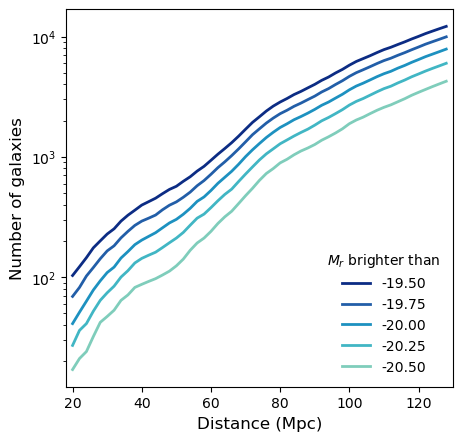

In [84]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot()

for (M_r_cutoff, c) in zip([-19.5, -19.75, -20.0, -20.25, -20.5], list(reversed(colors))):
    ax.plot(
        distances, 
        halos_cdf_distances_dict[M_r_cutoff], 
        label=f'{M_r_cutoff:.2f}',
        c=c,
        lw=2,
    )

ax.set_yscale('log')
ax.set_xlim(18, 130)
ax.set_xlabel('Distance (Mpc)', fontsize=12)
ax.set_ylabel('Number of galaxies', fontsize=12)

ax.legend(framealpha=0, title=r'$M_r$ brighter than', loc='lower right')

### Plot relative to L*

In [85]:
for M_r_cutoff in [-14.5, -17, -19.5, -21]:
    if M_r_cutoff not in halos_cdf_distances_dict.keys():
        halos_cdf_distances_dict[M_r_cutoff] = np.array([sum((M_r < M_r_cutoff) & (D_L < d)) for d in distances])

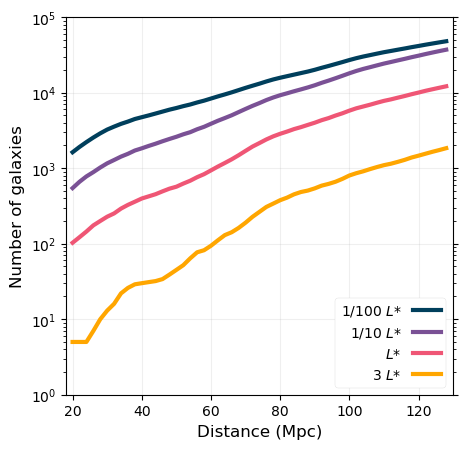

In [86]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot()

for (M_r_cutoff, c, l) in zip(
    [-14.5, -17, -19.5, -21], 
    ['#003f5c', '#7a5195', '#ef5675', '#ffa600'], 
    [r'1/100 $L$*', '1/10 $L$*', '$L$*', '3 $L$*']
):
    ax.plot(
        distances, 
        halos_cdf_distances_dict[M_r_cutoff], 
        label=l,
        c=c,
        lw=3,
    )

ax.grid(alpha=0.2)
    
ax.set_yscale('log')
ax.set_xlim(18, 130)
ax.set_ylim(1, 1e5)
ax.set_xlabel('Distance (Mpc)', fontsize=12)
ax.set_ylabel('Number of galaxies', fontsize=12)

ax.tick_params(right=True, which='both')

lg = ax.legend(framealpha=1, loc='lower right', markerfirst=False)
lg.get_frame().set_linewidth(0.2)

### Reference to specific galaxies/dwarfs

In [8]:
M_r = M_r[D_L < 130]
D_L = D_L[D_L < 130]

distances = range(20, 130, 2) # Mpc

In [9]:
halos_cdf_distances_dict = dict()
for M_r_cutoff in [-12.3, -13.8, -15.0, -17.0, -18.3, -19.8, -20.8]:
    if M_r_cutoff not in halos_cdf_distances_dict.keys():
        cutoff_range = (M_r < M_r_cutoff)
        halos_cdf_distances_dict[M_r_cutoff] = np.array([sum(cutoff_range & (D_L < d)) for d in distances])

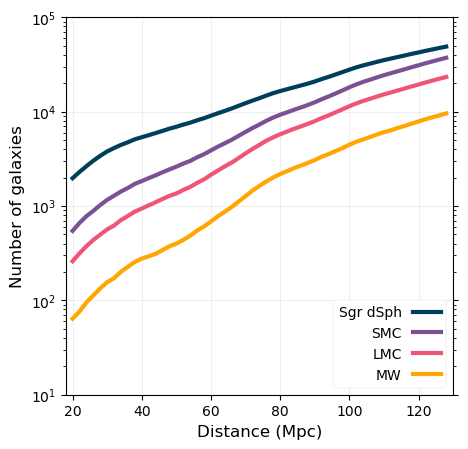

In [110]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot()

for (M_r_cutoff, c, l) in zip(
    [-13.8, -17.0, -18.3, -19.8], 
    ['#003f5c', '#7a5195', '#ef5675', '#ffa600'], 
    [r'Fornax', 'SMC', 'LMC', 'MW']
):
    ax.plot(
        distances, 
        halos_cdf_distances_dict[M_r_cutoff], 
        label=l,
        c=c,
        lw=3,
    )

ax.grid(alpha=0.2)
    
ax.set_yscale('log')
ax.set_xlim(18, 130)
ax.set_ylim(10, 1e5)
ax.set_xlabel('Distance (Mpc)', fontsize=12)
ax.set_ylabel('Number of galaxies', fontsize=12)

ax.tick_params(right=True, which='both')

lg = ax.legend(framealpha=1, loc='lower right', markerfirst=False)
lg.get_frame().set_linewidth(0.2)

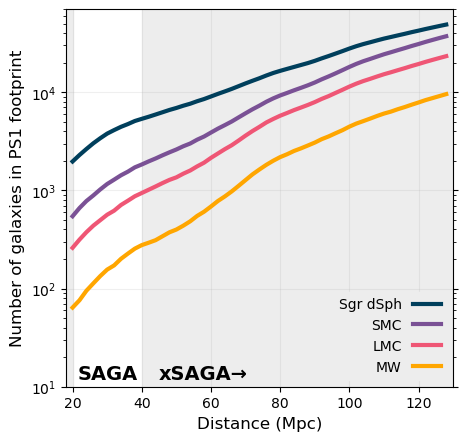

In [111]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot()

for (M_r_cutoff, c, l) in zip(
    [-13.8, -17.0, -18.3, -19.8], 
    ['#003f5c', '#7a5195', '#ef5675', '#ffa600'], 
    [r'Fornax', 'SMC', 'LMC', 'MW']
):
    ax.plot(
        distances, 
        halos_cdf_distances_dict[M_r_cutoff], 
        label=l,
        c=c,
        lw=3,
    )

ax.grid(alpha=0.2)

# use same style as other work
ax.axvspan(0, 20, color='0.93')
ax.axvspan(40, 130, color='0.93')

ax.text(21.5, 12, 'SAGA', c='black', weight='bold', fontsize=14)
ax.text(45, 12, 'xSAGA→', c='black', weight='bold', fontsize=14)
    
ax.set_yscale('log')
ax.set_xlim(18, 130)
ax.set_ylim(10, 7e4)
ax.set_xlabel('Distance (Mpc)', fontsize=12)
ax.set_ylabel('Number of galaxies in PS1 footprint', fontsize=12)

ax.tick_params(right=True, which='both')

lg = ax.legend(framealpha=1, loc='lower right', markerfirst=False)
lg.get_frame().set_color('0.93')

### Superimpose SAGA detection limits

In [13]:
hosts = pd.read_csv(f"{PATH}/data/saga_stage2_hosts.csv")
host_dist_cdf = np.array([sum(hosts.DIST < d) for d in np.array(distances)[SAGA_RANGE]]) * 100/36 # scaled up

In [217]:
for M_r_cutoff in [-13.0, -16.2, -17.5, -20.]: # actual galaxy M_r + 0.8 (to increase scatter)
    if M_r_cutoff not in halos_cdf_distances_dict.keys():
        cutoff_range = (M_r < M_r_cutoff)
        halos_cdf_distances_dict[M_r_cutoff] = np.array([sum(cutoff_range & (D_L < d)) for d in distances])

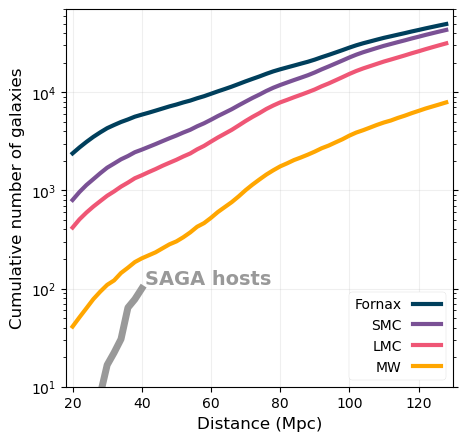

In [218]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot()

for (M_r_cutoff, c, l) in zip(
    [-13.0, -16.2, -17.5, -20.], 
    ['#003f5c', '#7a5195', '#ef5675', '#ffa600'], 
    [r'Fornax', 'SMC', 'LMC', 'MW']
):
    ax.plot(
        distances, 
        halos_cdf_distances_dict[M_r_cutoff], 
        label=l,
        c=c,
        lw=3,
    )

SAGA_RANGE = (np.array(distances) >= 20) & (np.array(distances) <= 40)
ax.plot(
    np.array(distances)[SAGA_RANGE], 
    host_dist_cdf, 
    c='0.6', ls='-', lw=5
)
ax.text(41, 110, 'SAGA hosts', c='0.6', fontsize=14, weight='bold')


ax.grid(alpha=0.2)
    
ax.set_yscale('log')
ax.set_xlim(18, 130)
ax.set_ylim(10, 7e4)
ax.set_xlabel('Distance (Mpc)', fontsize=12)
ax.set_ylabel('Cumulative number of galaxies, $N(M_r)$', fontsize=12)

ax.tick_params(right=True, which='both')

lg = ax.legend(framealpha=1, loc='lower right', markerfirst=False)
lg.get_frame().set_linewidth(0.2)

# plt.savefig('xSAGA-expected-numbers.pdf')

In [15]:
# above M_r + 0.8 (e.g., -20 for MW)
for M_r_cutoff in [-13.0, -16.2, -17.5, -20.]:
    print(halos_cdf_distances_dict[M_r_cutoff][-1])

49474
43076
31445
7877


In [16]:
# above M_r (e.g., -20.8 for MW)
for M_r_cutoff in [-13.8, -17.0, -18.3, -20.8]:
    print(halos_cdf_distances_dict[M_r_cutoff][-1])

48930
37150
23283
2655


Note that $M_r = -20$ is about 2x brighter than the MW in r-band absolute magnitude.

### Check within $\pm 1$ mag of the established range (for NSA)

In [126]:
# halos_range_cdf_distances_dict = dict()

for M_r_range in [-12.3, -13.9, -15.0, -17.0, -18.3, -20.8]:
    if M_r_range not in halos_range_cdf_distances_dict.keys():
        range_ = (M_r < M_r_range+1) & (M_r > M_r_range-1)
        halos_range_cdf_distances_dict[M_r_range] = np.array([sum(range_ & (D_L < d)) for d in distances])

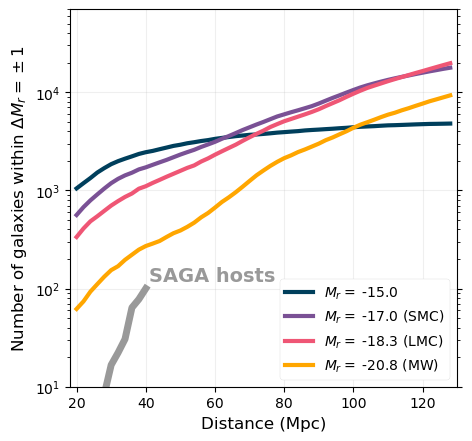

In [220]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot()

for (M_r_range, c, l) in zip(
    [-15.0, -17.0, -18.3, -20.8], 
    ['#003f5c', '#7a5195', '#ef5675', '#ffa600'], 
    [r'$M_r=$ -15.0', '$M_r=$ -17.0 (SMC)', '$M_r=$ -18.3 (LMC)', '$M_r=$ -20.8 (MW)']
):
    ax.plot(
        distances, 
        halos_range_cdf_distances_dict[M_r_range], 
        label=l,
        c=c,
        lw=3,
    )

SAGA_RANGE = (np.array(distances) >= 20) & (np.array(distances) <= 40)
ax.plot(
    np.array(distances)[SAGA_RANGE], 
    host_dist_cdf, 
    c='0.6', ls='-', lw=5
)
ax.text(41, 120, 'SAGA hosts', c='0.6', fontsize=14, weight='bold')


ax.grid(alpha=0.2)
    
ax.set_yscale('log')
ax.set_xlim(18, 130)
ax.set_ylim(10, 7e4)
ax.set_xlabel('Distance (Mpc)', fontsize=12)
ax.set_ylabel(r'Number of galaxies within $\Delta M_r = \pm 1$', fontsize=12)

ax.tick_params(right=True, which='both')

lg = ax.legend(framealpha=1, loc='lower right', markerfirst=True)
lg.get_frame().set_linewidth(0.2)


In [128]:
for M_r_range in [-13.8, -17.0, -18.3, -20.8]:
    print(halos_range_cdf_distances_dict[M_r_range][-1])

2196
17758
19735
9287


# Compare with LF estimates

See, e.g., [Loveday et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012MNRAS.420.1239L/abstract) with GAMA results in $r$-band, $z < 0.1$. 

Note also the power-law index $\alpha+1$ ([explanation](https://www.wikiwand.com/en/Luminosity_function_(astronomy)#/Schechter_luminosity_function)): 
$$ n(M)\, dM = 0.4 \ln 10 \phi^*  \cdot \left [10^{-0.4(M-M^*)}\right ]^{(\alpha + 1)} \cdot \exp(-10^{-0.4(M-M^*)})\, dM$$

## LFs

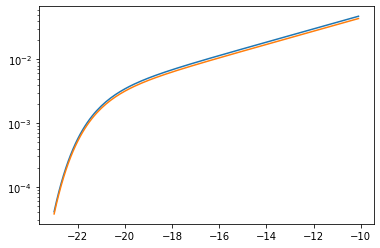

In [2]:
# r-band luminosity function
ϕ_star = 0.90 / (100/0.7**3)
α = -1.26                    # note +1 due to magnitudes
M_star_modulus = -20.73  + 5*np.log10(0.7)

ϕ_r = lambda M: ϕ_star * (10**(-0.4*(M - M_star_modulus)))**(α+1) * np.exp(-10**(-0.4*(M - M_star_modulus)))
logϕ_r = lambda M: np.log10(ϕ_star) + (α+1) *(-0.4*(M - M_star_modulus)) - 10**(-0.4*(M - M_star_modulus))

n_M_r = lambda M: 0.4*np.log(10)*ϕ_star * (10**(-0.4*(M-M_star_modulus)))**(α+1) * np.exp(-10**(-0.4*(M-M_star_modulus)))

r_mags = np.arange(-23, -10, 0.1)
plt.plot(r_mags, ϕ_r(r_mags))
plt.plot(r_mags, n_M_r(r_mags))
plt.yscale('log')

## Integrals of the LF and checking survey volumes

In [64]:
from scipy.integrate import quad

In [3]:
# MW-like objects
# n_MW_like, _ = quad(n_M_r, -21.6, -20.0)
n_MW_like, _ = quad(n_M_r, -21.6, -20.0)

n_MW_like # per Mpc^3

0.003222078584027325

So if SAGA has ~200 of these out between 20-40 Mpc, that's like a volume of 
$$ V_{\rm approx} = \frac{A}{3} \left[40^3 - 20^3 \right]\, {\rm Mpc}$$
where $A$ is the survey area in steradians. So then

$$n(M_{\rm MW}) \approx 0.003 = 200 \cdot \frac{3}{56000 A}$$

Then the effective area should be:

In [74]:
# effective area
(200 *3 / (56000 * .0032))

3.3482142857142856

Seems reasonable, that's close to $\pi$! And we know that the entire sky is $4\pi$ and SDSS covers a quarter of it. Granted, some should be lost due to the MW disk (low Galactic lattitudes) but whatever.

## Extend to 40 - 130 Mpc

Let's set survey area to $\pi$ for now, and multiply by 2 or 3 for Pan-STARRs later.

$$ N_{M_1, M_2} = n_{M_1, M_2} \times \frac{\pi}{3}\left [ 130^3 - 40^3\right] \approx 2.2\times 10^6 n_{M_1, M_2}$$

### Within $\pm 0.8$ mags

In [78]:
# ~about the MW
M_MW = -20.8

2.2e6 * quad(n_M_r, M_MW-0.8, M_MW+0.8)[0]

7088.572884860115

In [77]:
# ~about the LMC
M_LMC = -18.3

2.2e6 * quad(n_M_r, M_LMC-0.8, M_LMC+0.8)[0]

20544.766352041428

In [79]:
# ~about the SMC
M_SMC = -17.0

2.2e6 * quad(n_M_r, M_SMC-0.8, M_SMC+0.8)[0]

29129.470761660697

In [80]:
# ~about SAGA limit mag @ 130Mpc M=-15
M_SAGA_limit = -15

2.2e6 * quad(n_M_r, M_SAGA_limit-0.8, M_SAGA_limit+0.8)[0]

47680.79261287474

In [82]:
# ~about Fornax dwarf @ 130Mpc M=-13.8
M_Fornax = -13.8

2.2e6 * quad(n_M_r, M_Fornax-0.8, M_Fornax+0.8)[0]

63665.14959780937

In [150]:
# between 
2.2e6 * quad(n_M_r, -17.5, -15.0)[0]

55374.36404891221

### Within $\pm 1$ mag

In [84]:
for M_obj in [-20.8, -18.3, -17.0, -15, -13.8]:
    print(f"{2.2e6 * quad(n_M_r, M_obj-1, M_obj+1)[0]:.0f}")

8912
25740
36523
59802
79853


### Brighter than object

In [85]:
for M_obj in [-20.8, -18.3, -17.0, -15, -13.8]:
    print(f"{2.2e6 * quad(n_M_r, -25, M_obj)[0]:.0f}")

3669
24927
44879
91756
132979


### Brighter than ($M_{object} + 0.8$)

In [87]:
for M_obj in [-20.8, -18.3, -17.0, -15, -13.8]:
    print(f"{2.2e6 * quad(n_M_r, -25, M_obj+0.8)[0]:.0f}")

8213
36382
60921
117896
167861


## Plot some of these numbers

In [153]:
ds = np.arange(40, 130, 2)
V_eff = 3.348 / 3 * (ds**3)

xSAGA_MW = quad(n_M_r, -21.6, -20.0)[0] * V_eff

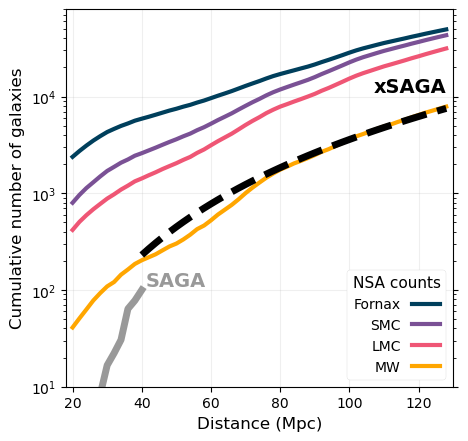

In [266]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot()

for (M_r_cutoff, c, l) in zip(
    [-13.0, -16.2, -17.5, -20.], 
    ['#003f5c', '#7a5195', '#ef5675', '#ffa600'], 
    [r'Fornax', 'SMC', 'LMC', 'MW']
):
    ax.plot(
        distances, 
        halos_cdf_distances_dict[M_r_cutoff], 
        label=l,
        c=c,
        lw=3,
    )

SAGA_RANGE = (np.array(distances) >= 20) & (np.array(distances) <= 40)
ax.plot(
    np.array(distances)[SAGA_RANGE], 
    host_dist_cdf, 
    c='0.6', ls='-', lw=5
)
ax.text(41, 110, 'SAGA', c='0.6', fontsize=14, weight='bold')


# xSAGA
ax.plot(ds, xSAGA_MW, c='k', ls='--', lw=5)
ax.text(128, 1.1e4, 'xSAGA', c='k', ha='right', fontsize=14, weight='bold')


ax.grid(alpha=0.2)
    
ax.set_yscale('log')
ax.set_xlim(18, 130)
ax.set_ylim(10, 8e4)
ax.set_xlabel('Distance (Mpc)', fontsize=12)
ax.set_ylabel('Cumulative number of galaxies', fontsize=12)

ax.tick_params(right=True, which='both')

lg = ax.legend(framealpha=1, loc='lower right', title='NSA counts', markerfirst=False)
lg.get_frame().set_linewidth(0.2)
lg.get_title().set_fontsize(11)

plt.savefig('xSAGA-expected-numbers.pdf')

## Show all number counts (perhaps too cluttered)

In [145]:
import matplotlib.patheffects as mpe

path_effects = [mpe.Stroke(linewidth=6, foreground='w'), mpe.Normal()]

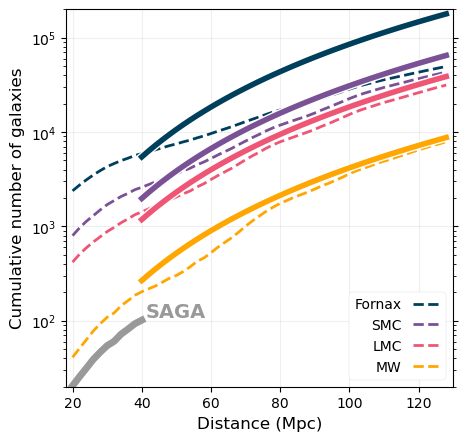

In [147]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot()

for (M_r_cutoff, c, l) in zip(
    [-13.0, -16.2, -17.5, -20.], 
    ['#003f5c', '#7a5195', '#ef5675', '#ffa600'], 
    [r'Fornax', 'SMC', 'LMC', 'MW']
):
    ax.plot(
        distances, 
        halos_cdf_distances_dict[M_r_cutoff], 
        label=l,
        c=c,
        ls='--',
        lw=2,
    )
    
    # xSAGA
    ax.plot(ds, quad(n_M_r, -25, M_r_cutoff)[0] * V_eff, c=c, ls='-', lw=4, path_effects=path_effects)

SAGA_RANGE = (np.array(distances) >= 20) & (np.array(distances) <= 40)
ax.plot(
    np.array(distances)[SAGA_RANGE], 
    halos_cdf_distances_dict[-20.8 + 0.8][SAGA_RANGE]/2, 
    c='0.6', ls='-', lw=5
)
ax.text(41, 110, 'SAGA', c='0.6', fontsize=14, weight='bold')



ax.grid(alpha=0.2)
    
ax.set_yscale('log')
ax.set_xlim(18, 130)
ax.set_ylim(20, 2e5)
ax.set_xlabel('Distance (Mpc)', fontsize=12)
ax.set_ylabel('Cumulative number of galaxies', fontsize=12)

ax.tick_params(right=True, which='both')

lg = ax.legend(framealpha=1, loc='lower right', markerfirst=False)
lg.get_frame().set_linewidth(0.2)

# plt.savefig('xSAGA-expected-numbers.pdf')

## Expected numbers (LF perspective)

In [166]:
# halos_range_cdf_distances_dict = dict()

for M_r_range in [-12.3, -13.8, -15.0, -17.0, -18.3, -20.8]:
    if M_r_range not in halos_range_cdf_distances_dict.keys():
        range_ = (M_r < M_r_range+1) & (M_r > M_r_range-1)
        halos_range_cdf_distances_dict[M_r_range] = np.array([sum(range_ & (D_L < d)) for d in distances])

In [168]:
halos_range_cdf_distances_dict[M_r_range][-1]

9287

In [186]:
M_r_range-1

-21.8

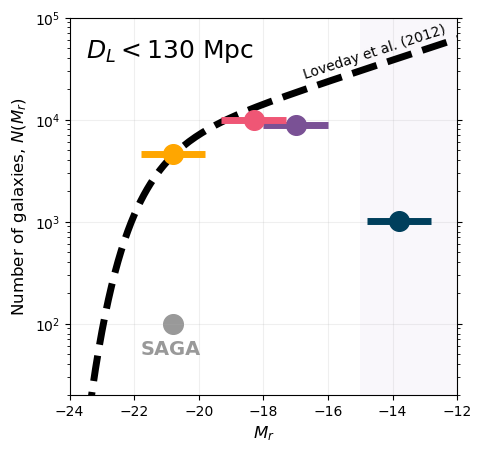

In [287]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot()

# plot LF
r_mags = np.arange(-25, -10, 0.1)
volume_ = (np.pi/3*(130**3-40**3)) 

ax.plot(r_mags, n_M_r(r_mags)*volume_, c='k', ls='--', lw=5)
ax.set_yscale('log')

# scatter plots
for (M_r_range, c, l) in zip(
    [-13.8, -17.0, -18.3, -20.8], 
    ['#003f5c', '#7a5195', '#ef5675', '#ffa600'], 
    [r'Fornax', 'SMC', 'LMC', 'MW']
):
    num = halos_range_cdf_distances_dict[M_r_range][-1] / 2
    ax.scatter(M_r_range, num, c=c, s=200, zorder=9)
    ax.hlines(num, xmin=M_r_range-1, xmax=M_r_range+1,  color=c, lw=5, zorder=9)

    
ax.scatter(-20.8, 100, c='0.6', s=200)
ax.text(-21.8, 50, 'SAGA', c='0.6', fontsize=14, weight='bold')

    
ax.tick_params(right=True, which='both')

# completeness
ax.axvspan(-15, -10, alpha=0.05, color='C4', lw=0)

ax.text(-23.5, 4e4, "$D_L < 130$ Mpc", fontsize=18, color='black')
ax.text(-16.8, 2.5e4, 'Loveday et al. (2012)', fontsize=10, rotation=18)

ax.set_xlim(-24, -12)
ax.set_ylim(20, 1e5)

ax.grid(alpha=0.2)


ax.set_xlabel('$M_r$', fontsize=12)
ax.set_ylabel('Number of galaxies, $N(M_r)$', fontsize=12)

plt.savefig(f'xSAGA-projected-LF.pdf')

Looks like at $M_r=-13.8$ we can expect up to $\sim 40\times$ the number of sources, while at $M_r = -15.0$ (completeness limit) we can expect $\sim 8 \times$ more

~~Get SAGA S2 LF?~~ No that's not really a luminosity function...

In [198]:
SAGA_vol = 36*np.pi * (0.3)**2 * 20 # Mpc^3
saga = pd.read_csv(f"{PATH}/data/saga_stage2_sats.csv")

saga_LF = np.array([sum(saga.R_ABS < R_) + (36 if R_ >= -20.8 else 0) for R_ in r_mags]) / SAGA_vol

In [200]:
saga.R_ABS

0     -15.9
1     -15.7
2     -14.8
3     -14.0
4     -15.9
       ... 
122   -16.8
123   -14.9
124   -12.1
125   -19.0
126   -17.1
Name: R_ABS, Length: 127, dtype: float64

# Simplifying the $N(<M_r)$ figurefigure

In [ ]:
hosts = pd.read_csv(f"{PATH}/data/saga_stage2_hosts.csv")
host_dist_cdf = np.array([sum(hosts.DIST < d) for d in np.array(distances)[SAGA_RANGE]]) * 100/36 # scaled up

In [20]:
ds = np.arange(40, 130, 2)
V_eff = 3.348 / 3 * (ds**3)

xSAGA_MW = quad(n_M_r, -21.6, -20.0)[0] * V_eff

In [73]:
xSAGA_LMC = quad(n_M_r, -21.6, -17.5)[0] * V_eff

In [11]:
for M_r_cutoff in [17.5, -20.]:
    if M_r_cutoff not in halos_cdf_distances_dict.keys():
        cutoff_range = (M_r < M_r_cutoff)
        halos_cdf_distances_dict[M_r_cutoff] = np.array([sum(cutoff_range & (D_L < d)) for d in distances])

In [152]:
halos_cdf_distances_MW_LMC = dict()

for M_r_cutoff in [17.5, -20.]:
    if M_r_cutoff not in halos_cdf_distances_MW_LMC.keys():
        cutoff_range = (M_r < M_r_cutoff) & (M_r > -21.6)
        halos_cdf_distances_MW_LMC[M_r_cutoff] = np.array([sum(cutoff_range & (D_L < d)) for d in distances])

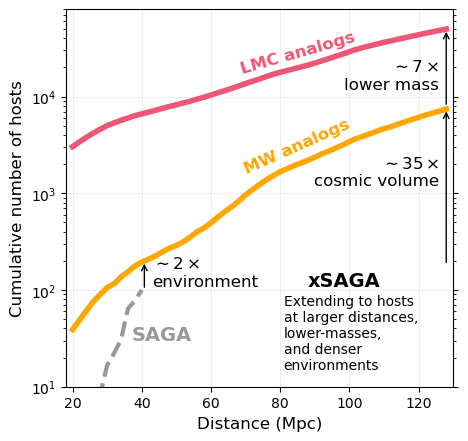

In [160]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot()

for (M_r_cutoff, c, l) in zip(
    [17.5, -20.], 
    ['#ef5675', '#ffa600'], 
    ['LMC', 'MW']
):
    ax.plot(
        distances, 
        halos_cdf_distances_MW_LMC[M_r_cutoff], 
        label=l,
        c=c,
        lw=4,
    )

    
# xSAGA

SAGA_RANGE = (np.array(distances) >= 20) & (np.array(distances) <= 40)
ax.plot(
    np.array(distances)[SAGA_RANGE], 
    host_dist_cdf, 
    c='0.6', ls='--', lw=3
)
ax.text(37, 30, 'SAGA', c='0.6', fontsize=14, weight='bold')


# xSAGA
# ax.plot(ds, xSAGA_MW, c='k', ls='--', lw=2)
# ax.text(128, 1.1e4, 'xSAGA', c='k', ha='right', fontsize=14, weight='bold')

# xSAGA increases
ax.annotate(r'', xy=(40.75, 200), xytext=(40.75, 100), arrowprops=dict(arrowstyle="->"))
ax.text(43, 110, r'$\sim 2\times$' '\nenvironment', fontsize=12)

ax.annotate(r'', xy=(128, 7500), xytext=(128, 180), arrowprops=dict(arrowstyle="->"))
ax.text(126, 1200, r'$\sim 35\times$' '\ncosmic volume' , fontsize=12, ha='right')

ax.annotate(r'', xy=(128, 5.e4), xytext=(128, 7800), arrowprops=dict(arrowstyle="->"))
ax.text(126, 1.2e4, r'$\sim 7\times$' '\nlower mass' , fontsize=12, ha='right')

# more labels
ax.text(88, 1.1e2, 'xSAGA', c='k', ha='left', fontsize=14, weight='bold')
ax.text(81, 1.5e1, 'Extending to hosts\n' 'at larger distances,\n' 'lower-masses,\n''and denser\n' 'environments', c='k', ha='left', fontsize=10)
ax.text(85, 1.6e3, 'MW analogs', ha='center', color='#ffa600', fontsize=12, weight='bold', rotation=24)
ax.text(85, 1.75e4, 'LMC analogs', ha='center', color='#ef5675', fontsize=12, weight='bold', rotation=16)


ax.grid(alpha=0.2)
    
ax.set_yscale('log')
ax.set_xlim(18, 130)
ax.set_ylim(10, 8e4)
ax.set_xlabel('Distance (Mpc)', fontsize=12)
ax.set_ylabel('Cumulative number of hosts', fontsize=12)

ax.tick_params(right=True, which='both')

plt.savefig('xSAGA-expected-numbers.pdf')